# Interest Rates Carry Strategy from Goldman Sachs
* what was wrong before

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

---
# Read the Data
Only needed for reading from excel

Yield Curve and Country trackers

In [3]:
# Country ID in the yield curve worksheet
country_code = {'US': '082',  # United States
                'AU': '127',  # Australia
                'CA': '101',  # Canada
                'GE': '910',  # Germany
                'UK': '110',  # United Kingdom
                'JP': '105',  # Japan
                'FR': '915',  # France
                'IT': '905'}  # Italy


# Available tenors
tenors_month = [3, 6, 12, 2*12, 3*12, 4*12, 5*12, 6*12, 7*12, 8*12, 9*12, 10*12, 15*12, 20*12, 30*12]


# generates the ticker for a given country and tenor
def gen_ticker(tenor, country):

    if tenor < 12:
        t_code = '0' + str(tenor) + 'M Index'

    else:
        t_code = str(int(tenor/12)).zfill(2) + 'Y Index'

    ticker = 'F' + country_code[country] + t_code

    return ticker


# Read the excel worksheet
df_zcc = pd.read_excel(r'data\zero coupon curves.xlsx',
                       sheet_name='values',
                       index_col='Dates').multiply(1/100)

In [6]:
df_trackers = pd.DataFrame()
df_trackers_last_rebal = pd.DataFrame()
rebal_dates = {}

for ctry in tqdm(country_code.keys(), 'Reading Trackers'):
    df = pd.read_excel(r'data\df_' + str(ctry) + '.xlsx')
    tracker = df['er_index']
    tracker.name = ctry
    df_trackers = pd.concat([df_trackers, tracker], axis=1)

    roll_dates = df['roll_out_date'].dropna().values
    tracker_at_last_rebal = tracker.resample('D').last().fillna(method='ffill').reindex(roll_dates).resample('D').last().fillna(method='ffill')
    df_trackers_last_rebal = pd.concat([df_trackers_last_rebal, tracker_at_last_rebal], axis=1)

df_trackers_last_rebal = df_trackers_last_rebal.reindex(df_trackers.index).fillna(method='ffill').fillna(method='bfill')

Reading Trackers: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.34it/s]


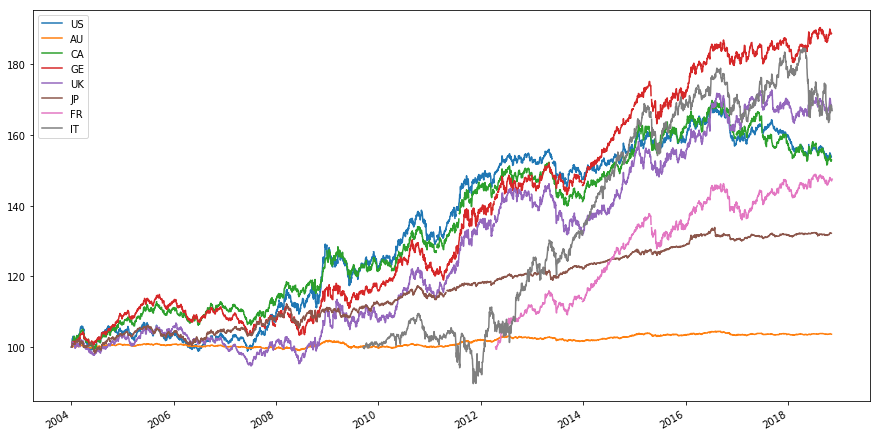

In [7]:
df_trackers.plot(figsize=(15, 8))
plt.show()

---
# Calculate the Carry Signal

In [8]:
def calc_duration(ytm, t=10, dy=0.0001):

    ytm_minus = ytm - dy
    ytm_plus = ytm + dy
    price0 = 100/((1+ytm) ** t)
    price_minus = 100/((1+ytm_minus) ** t)
    price_plus = 100 / ((1 + ytm_plus) ** t)
    dur = (price_minus - price_plus)/(2*price0*dy)

    return dur

In [9]:
df_carry = pd.DataFrame()

for ctry in tqdm(country_code.keys(), 'Building Carry'):

    ticker_list = [gen_ticker(t, ctry) for t in tenors_month]  # gets the tickers for thar country
    df_ctry = df_zcc[ticker_list]  # gets the verticies for the country

    df_curve = pd.DataFrame(index=df_ctry.index, columns=list(range(3, 30 * 12 + 1)), dtype=float)

    for t, tick in zip(tenors_month, ticker_list):
        if t in tenors_month:
            df_curve[t] = df_ctry[tick]

    df_curve = df_curve.dropna(how='all').interpolate(axis=1, method='pchip')

    dur = calc_duration(ytm=df_curve[12 * 10])
    ctry_carry = df_curve[10*12] - df_curve[3] - dur*(df_curve[10*12] - df_curve[9*12 + 9])
    ctry_carry.name = ctry
    df_carry = pd.concat([df_carry, ctry_carry], axis=1)

Building Carry: 100%|████████████████████████████████████████████████████████████████████| 8/8 [00:45<00:00,  5.63s/it]


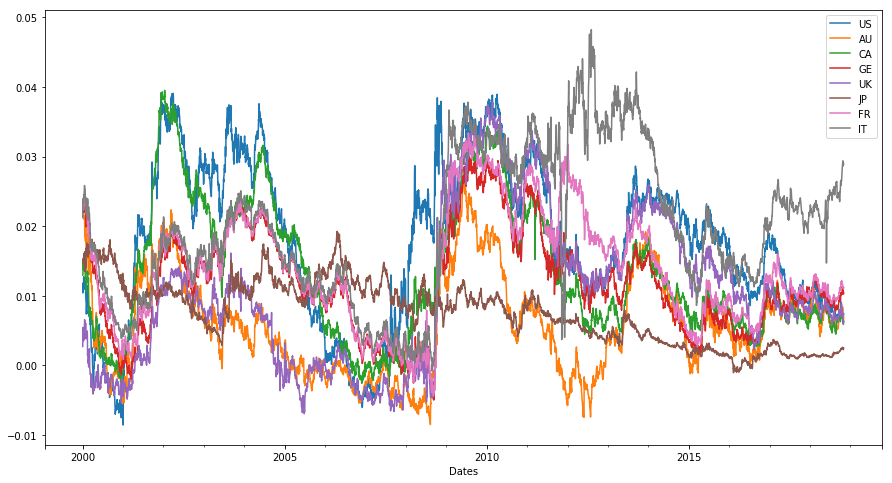

In [11]:
df_carry.plot(figsize=(15, 8))
plt.show()

---
# Tracker betas to TY using shrinkage estimator
* Whats is shirinkage?

In [12]:
cov_window = 63
shrinkage_parameter = 0.5

df_returns = df_trackers.pct_change(1)
cov_matrix = df_returns.shift(1).rolling(cov_window).cov()
corr_matrix = df_returns.shift(1).rolling(cov_window).corr()
df_carry = df_carry.reindex(df_trackers.index).fillna(method='ffill')

calendar = cov_matrix.dropna(how='all').index.get_level_values(0).unique()

shrunk_cov_matrix = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns)
df_vols = pd.DataFrame(index=calendar, columns=country_code.keys())
df_betas = pd.DataFrame(index=calendar, columns=country_code.keys())

for d in tqdm(calendar, 'Betas and Covariances'):

    available_countries = list(cov_matrix.loc[d].dropna(how='all').dropna(how='all', axis=1).index)
    vols = np.diag(np.array(cov_matrix.loc[d][available_countries].loc[available_countries]).diagonal()**0.5)
    corr = (1 - shrinkage_parameter) * np.array(corr_matrix.loc[d][available_countries].loc[available_countries]) + shrinkage_parameter * np.eye(len(vols))
    shrunk_cov_matrix.loc[d].loc[available_countries, available_countries] = vols.dot(corr).dot(vols) * 252
    df_vols.loc[d][available_countries] = vols.diagonal()
    df_betas.loc[d][available_countries] = shrunk_cov_matrix.loc[d, 'US'][available_countries] / shrunk_cov_matrix.loc[d, 'US'].loc['US']

Betas and Covariances: 100%|██████████████████████████████████████████████████████| 3805/3805 [00:35<00:00, 108.58it/s]


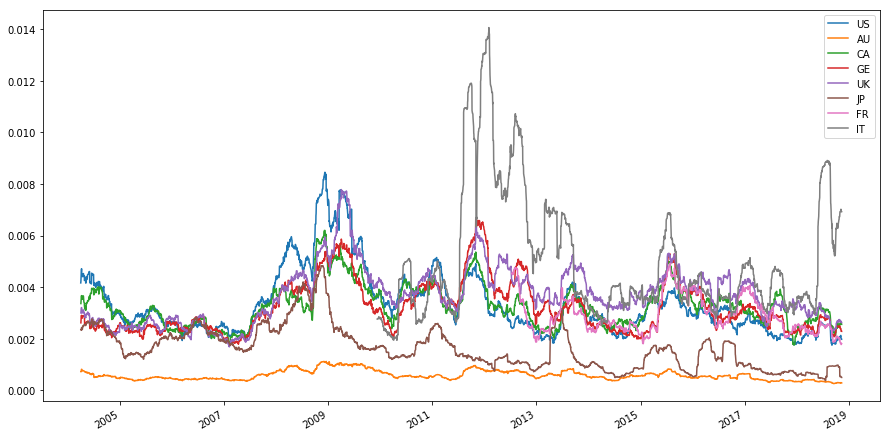

In [15]:
df_vols.plot(figsize=(15, 8))
plt.show()

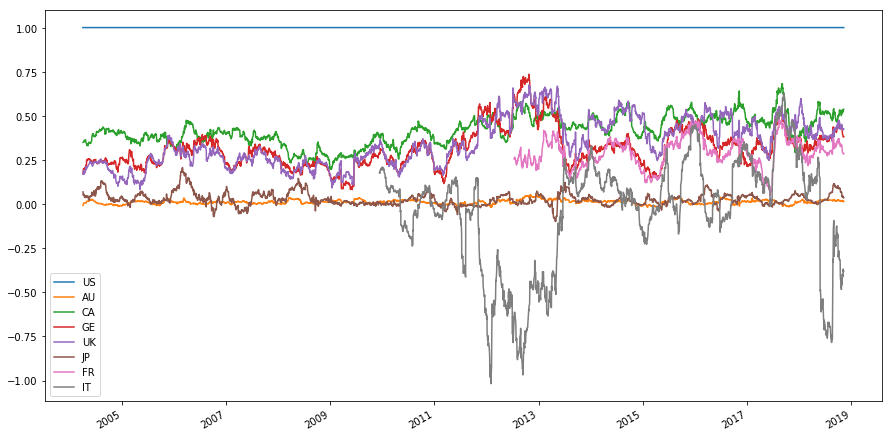

In [16]:
df_betas.plot(figsize=(15, 8))
plt.show()

---
# Find the Weights of the Strategy

In [17]:
country_bounds = {'US': [-0.8, 0.8],  # United States
                  'AU': [-0.8, 0.8],  # Australia
                  'CA': [-0.8, 0.8],  # Canada
                  'GE': [-0.8, 0.8],  # Germany
                  'UK': [-0.8, 0.8],  # United Kingdom
                  'JP': [-0.8, 0.8],  # Japan
                  'FR': [-0.4, 0.4],  # France
                  'IT': [-0.4, 0.4]}  # Italy

bounds = pd.DataFrame(data=country_bounds, index=['lower', 'upper']).T
bounds

,lower,upper
US,-0.8,0.8
AU,-0.8,0.8
CA,-0.8,0.8
GE,-0.8,0.8
UK,-0.8,0.8
JP,-0.8,0.8
FR,-0.4,0.4
IT,-0.4,0.4


In [18]:
vol_target = 0.05
total_gross_weights = 2

df_weights = pd.DataFrame(index=calendar, columns=country_code.keys())

for d in tqdm(calendar, 'Weights Optimization'):

    available_countries = list(cov_matrix.loc[d].dropna(how='all').dropna(how='all', axis=1).index)

    cov = np.array(shrunk_cov_matrix.loc[d, available_countries].loc[available_countries])
    betas = np.array(df_betas.loc[d, available_countries])
    mu = np.array(df_carry.loc[d, available_countries])

    port_carry = lambda w: -mu.dot(w)
    port_net_vol = lambda w: float(w.dot(cov).dot(w.T))**0.5
    port_gross_weights = lambda w: np.sum(np.abs(w))
    port_beta = lambda w: np.dot(betas, w)

    cons = ({'type': 'ineq', 'fun': lambda w: vol_target - port_net_vol(w)},
            {'type': 'eq', 'fun': lambda w: 0 - port_beta(w)},
            {'type': 'ineq', 'fun': lambda w: total_gross_weights - port_gross_weights(w)})

    w0 = np.zeros(len(available_countries))

    res = minimize(fun=port_carry,
                   x0=w0,
                   method='SLSQP',
                   bounds=bounds.loc[available_countries].values,
                   constraints=cons)

    if res.success:
        df_weights.loc[d][available_countries] = res.x
        
df_weights = df_weights.fillna(method='ffill')

Weights Optimization: 100%|████████████████████████████████████████████████████████| 3805/3805 [01:12<00:00, 52.69it/s]


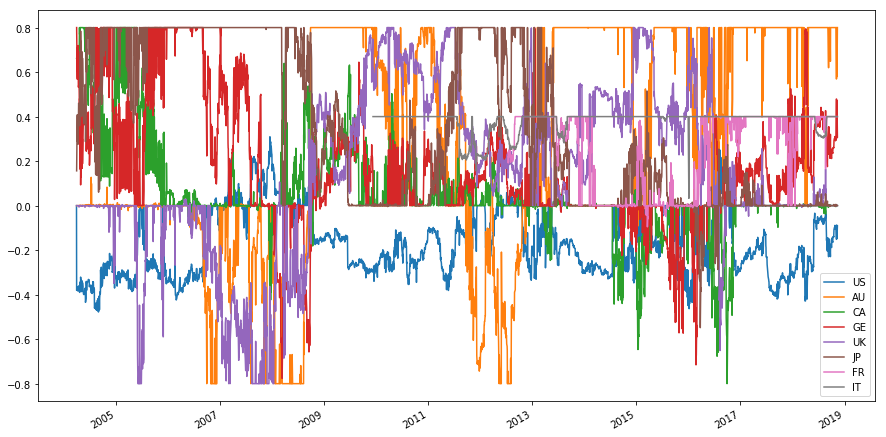

In [19]:
df_weights.plot(figsize=(15, 8))
plt.show()

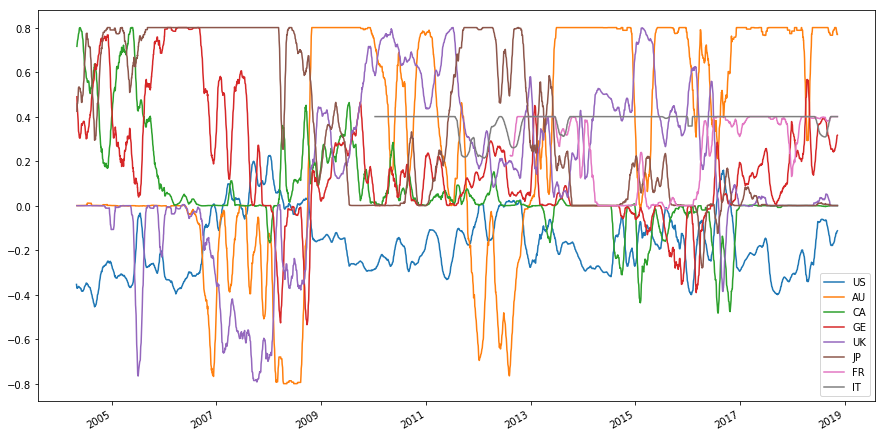

In [20]:
df_smooth_weights = df_weights.rolling(22).mean()

df_smooth_weights.plot(figsize=(15, 8))
plt.show()

---
# Build the Index for the Strategy

In [28]:
calendar = df_smooth_weights.dropna(how='all').index
df_tracker_diff = df_trackers.diff(1)
strat_index = pd.DataFrame(index=calendar, columns=['tr_index', 'tr_net_costs'])
df_tracker_rebal_diff = df_trackers_last_rebal.diff(1)

In [29]:
strat_index['tr_index'].iloc[0] = 100
holdings = 100 * df_smooth_weights.loc[calendar[0]] / df_trackers_last_rebal.loc[calendar[0]]

for d, dm1 in tqdm(zip(calendar[1:], calendar[:-1])):

    pnl = (holdings * df_tracker_diff.loc[d]).sum()
    strat_index['tr_index'].loc[d] = strat_index['tr_index'].loc[dm1] + pnl
    holdings = strat_index['tr_index'].loc[d] * df_smooth_weights.loc[d] / df_trackers_last_rebal.loc[d]

3783it [00:04, 817.75it/s]


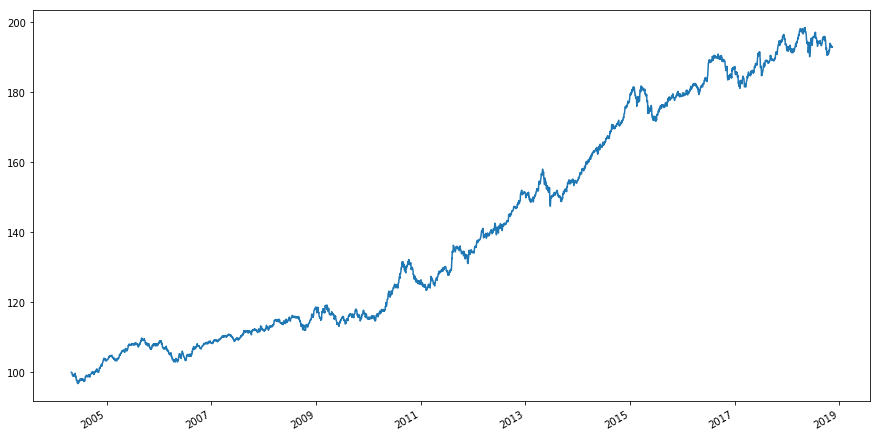

In [40]:
strat_index['tr_index'].plot(figsize=(15, 8))
plt.show()

Now Including costs

In [41]:
country_costs = {'US': [2.0, 1.0],  # United States
                 'AU': [5.0, 3.0],  # Australia
                 'CA': [2.5, 1.0],  # Canada
                 'GE': [1.5, 1.0],  # Germany
                 'UK': [2.5, 1.0],  # United Kingdom
                 'JP': [2.5, 1.0],  # Japan
                 'FR': [3.0, 2.0],  # France
                 'IT': [3.0, 2.0]}  # Italy

df_costs = pd.DataFrame(data=country_costs, index=['rebalance', 'roll']).multiply(1/10000).T

In [46]:
strat_index['tr_net_costs'].iloc[0] = 100
holdings = 100 * df_smooth_weights.loc[calendar[0]] / df_trackers_last_rebal.loc[calendar[0]]

rebal_cost_d = 0
roll_cost_d = 0

for d, dm1 in tqdm(zip(calendar[1:], calendar[:-1])):

    pnl = (holdings * df_tracker_diff.loc[d]).sum()
    strat_index['tr_net_costs'].loc[d] = strat_index['tr_net_costs'].loc[dm1] + pnl - rebal_cost_d - roll_cost_d

    roll_cost_d = (((df_tracker_rebal_diff.loc[d] != 0) * holdings).abs() * df_costs['roll']).sum()

    new_holdings = strat_index['tr_net_costs'].loc[d] * df_smooth_weights.loc[d] / df_trackers_last_rebal.loc[d]
    rebal_cost_d = ((new_holdings - holdings).abs() * df_costs['rebalance']).sum()
    holdings = new_holdings.copy()

3783it [00:08, 440.09it/s]


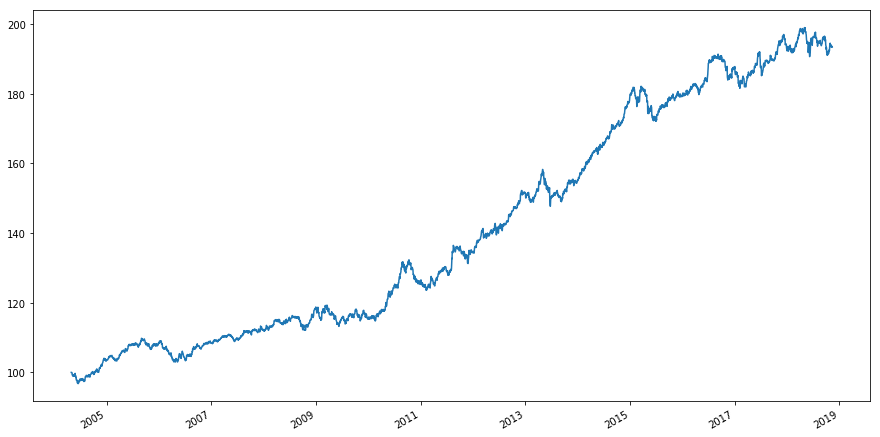

In [47]:
strat_index['tr_net_costs'].plot(figsize=(15, 8))
plt.show()

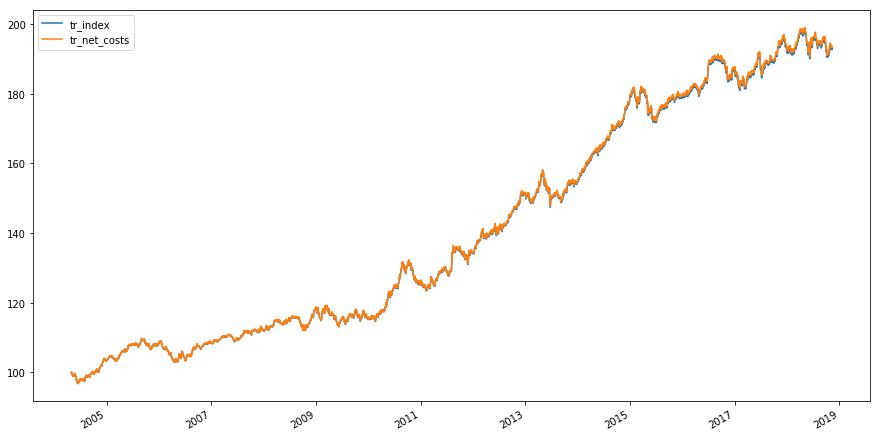

In [48]:
strat_index.plot(figsize=(15, 8))
plt.show()